## Multichannel autoencoders for anomaly detection example

In [1]:
%load_ext autoreload
#%load_ext nb_black
%load_ext autotime
%autoreload 2


from matplotlib import pyplot as plt
import random
import numpy as np
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

plt.rcParams["figure.figsize"] = [10, 2]
plt.rcParams["figure.dpi"] = 200

random.seed(42)
np.random.seed(42)

time: 421 ms (started: 2024-05-28 15:46:55 -07:00)


### Generate a synthetic time series

<Axes: >

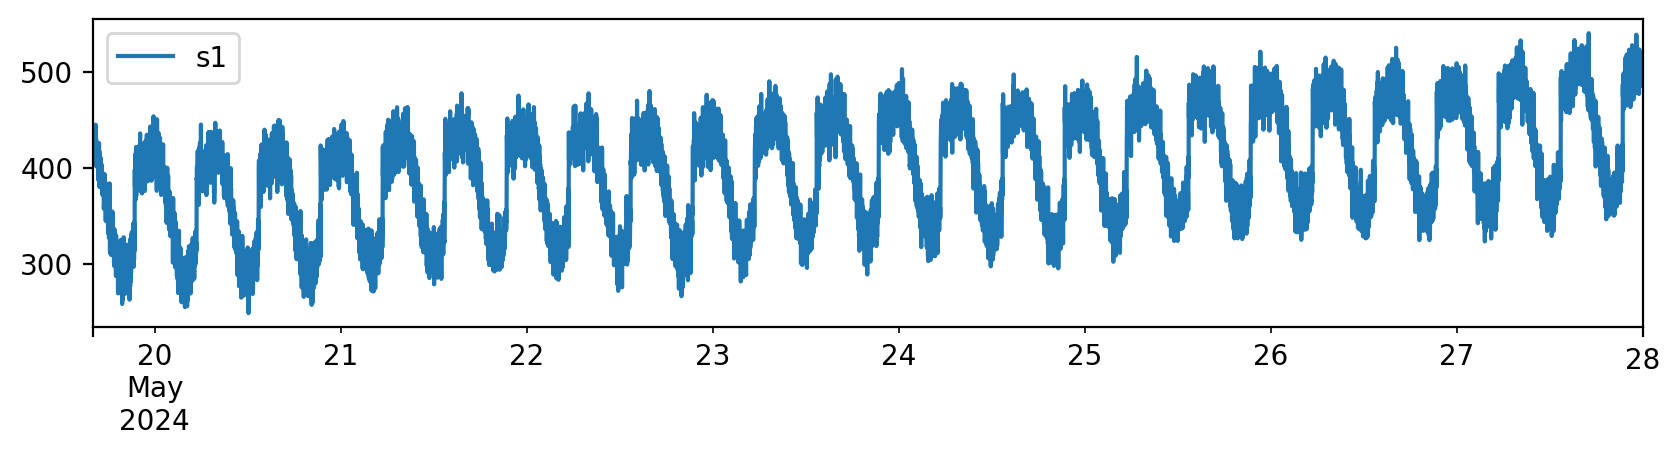

time: 1.83 s (started: 2024-05-28 15:46:55 -07:00)


In [2]:
from numalogic.synthetic import SyntheticTSGenerator
from numalogic.synthetic import AnomalyGenerator

ts_generator = SyntheticTSGenerator(
    seq_len=12000,
    num_series=1,
    freq="T",
    primary_period=480,
    secondary_period=3000,
    seasonal_ts_prob=1.0,
    baseline_range=(200.0, 350.0),
    slope_range=(-0.001, 0.01),
    amplitude_range=(10, 75),
    cosine_ratio_range=(0.5, 0.9),
    noise_range=(10, 15),
)
ts_df = ts_generator.gen_tseries()
ts_df.plot()

### Divide into train, test and validation set

In [3]:
train_df, test_df = ts_generator.train_test_split(ts_df, test_size=2400)
train_df, val_df = ts_generator.train_test_split(train_df, test_size=2000)
train_df.shape, val_df.shape, test_df.shape

((7600, 1), (2000, 1), (2400, 1))

time: 2.47 ms (started: 2024-05-28 15:46:57 -07:00)


### Inject synthetic anomalies in the test data
Let's generate a contextual anomaly with a low impact.


In [4]:
anomaly_generator = AnomalyGenerator(
    train_df, anomaly_type="contextual", anomaly_ratio=0.2
)
outlier_test_df = anomaly_generator.inject_anomalies(test_df, cols=["s1"], impact=3)

time: 7.77 ms (started: 2024-05-28 15:46:57 -07:00)


<Axes: >

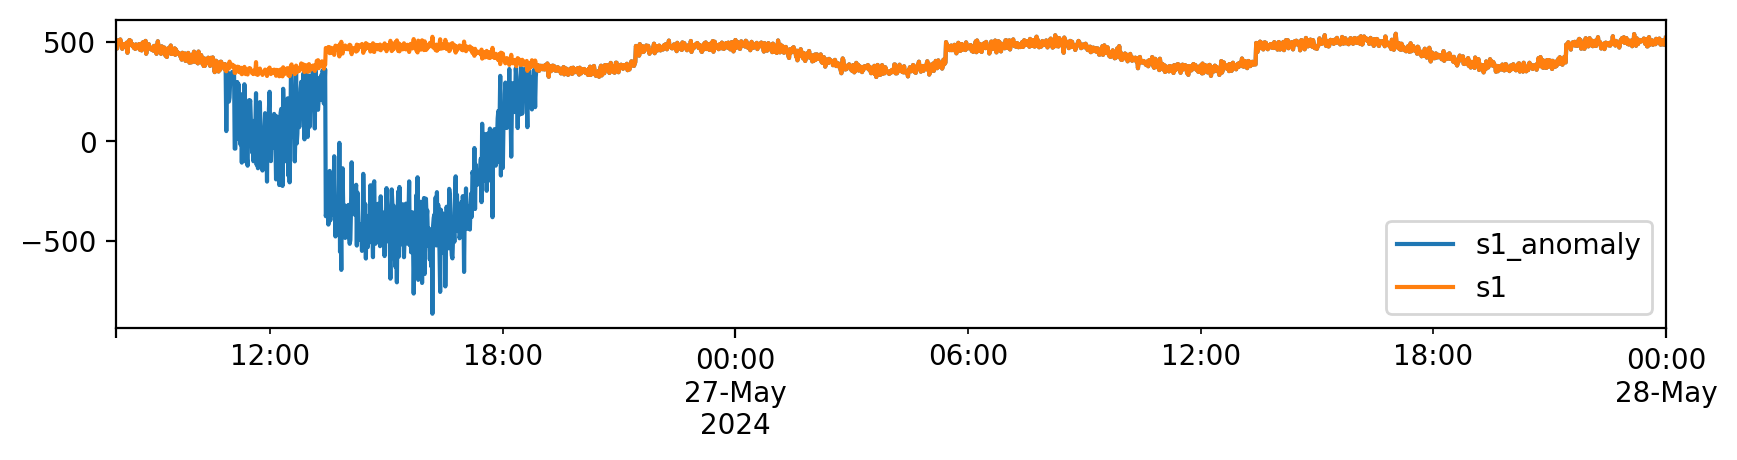

time: 430 ms (started: 2024-05-28 15:46:57 -07:00)


In [5]:
outlier_test_df.rename(columns={"s1": "s1_anomaly"}, inplace=True)
fig, ax = plt.subplots()
outlier_test_df[["s1_anomaly"]].plot(ax=ax)
test_df.plot(ax=ax)

### Preprocess the data
We will use the Tanh scaler here from numalogic.
Add two more columns to the train and test dataframes to simulate a multichannel time series. Make the second column an anomaly column.

In [6]:
from numalogic.transforms import TanhScaler

# Adding two more columns
train_df['s2'] = train_df['s1']
train_df['s3'] = train_df['s1']

test_df['s2'] = test_df['s1']
test_df['s3'] = test_df['s1']

val_df['s2'] = test_df['s1']
val_df['s3'] = test_df['s1']

# The second column is with anomalies, the rest are normal
outlier_test_df['s1'] = test_df['s1']
outlier_test_df['s2'] = outlier_test_df['s1_anomaly']
outlier_test_df['s3'] = test_df['s1']

scaler = TanhScaler()
x_train = scaler.fit_transform(train_df.to_numpy())
x_val = scaler.transform(val_df.to_numpy())
x_test = scaler.transform(outlier_test_df[['s1', 's2', 's3']].to_numpy())
x_test_good = scaler.transform(test_df.to_numpy())

time: 2.05 s (started: 2024-05-28 15:46:57 -07:00)


Show the shape of the data

In [7]:
print(x_train.shape)
x_train[:2]

(7600, 3)


array([[0.56362768, 0.56362768, 0.56362768],
       [0.54255676, 0.54255676, 0.54255676]])

time: 2.67 ms (started: 2024-05-28 15:47:00 -07:00)


### Define model training parameters
First, we will prepare some torch datasets

In [8]:
from numalogic.tools.data import StreamingDataset
from torch.utils.data import DataLoader


SEQ_LEN = 12
BATCH_SIZE = 64
MAX_EPOCHS = 40

train_dataset = StreamingDataset(x_train, seq_len=SEQ_LEN)
val_dataset = StreamingDataset(x_val, seq_len=SEQ_LEN)
test_dataset = StreamingDataset(x_test, seq_len=SEQ_LEN)

time: 2.51 ms (started: 2024-05-28 15:47:00 -07:00)


Show again a sample of the train data

In [9]:
train_dataset[0]

array([[0.56362766, 0.56362766, 0.56362766],
       [0.54255676, 0.54255676, 0.54255676],
       [0.58594453, 0.58594453, 0.58594453],
       [0.58339155, 0.58339155, 0.58339155],
       [0.56559443, 0.56559443, 0.56559443],
       [0.59189177, 0.59189177, 0.59189177],
       [0.575449  , 0.575449  , 0.575449  ],
       [0.5419866 , 0.5419866 , 0.5419866 ],
       [0.57273036, 0.57273036, 0.57273036],
       [0.53916323, 0.53916323, 0.53916323],
       [0.58506376, 0.58506376, 0.58506376],
       [0.56171334, 0.56171334, 0.56171334]], dtype=float32)

time: 2.39 ms (started: 2024-05-28 15:47:00 -07:00)


Define a vanilla autoencoder model

In [10]:
from numalogic.models.autoencoder.variants import VanillaAE
from numalogic.models.autoencoder import TimeseriesTrainer

model_vanilla = VanillaAE(seq_len=SEQ_LEN, n_features=1)
print(model_vanilla)

VanillaAE(
  (encoder): _VanillaEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=12, out_features=16, bias=True)
      (1): Tanh()
      (2): Dropout(p=0.25, inplace=False)
      (3): Linear(in_features=16, out_features=8, bias=True)
      (4): Tanh()
      (5): Dropout(p=0.25, inplace=False)
    )
  )
  (decoder): _Decoder(
    (decoder): Sequential(
      (0): Linear(in_features=8, out_features=16, bias=True)
      (1): Tanh()
      (2): Dropout(p=0.25, inplace=False)
      (3): Linear(in_features=16, out_features=12, bias=True)
    )
  )
)
time: 14.4 ms (started: 2024-05-28 15:47:00 -07:00)


In [11]:
trainer = TimeseriesTrainer(max_epochs=MAX_EPOCHS, enable_progress_bar=True)
trainer.fit(model_vanilla, train_dataloaders=DataLoader(train_dataset, batch_size=BATCH_SIZE))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=40` reached.


time: 20.3 s (started: 2024-05-28 15:47:00 -07:00)


In [12]:
train_reconerr_vanilla = trainer.predict(
    model_vanilla, dataloaders=DataLoader(train_dataset, batch_size=BATCH_SIZE)
).numpy()
val_reconerr_vanilla = trainer.predict(
    model_vanilla, dataloaders=DataLoader(val_dataset, batch_size=BATCH_SIZE)
).numpy()
test_reconerr_vanilla = trainer.predict(
    model_vanilla, dataloaders=DataLoader(test_dataset, batch_size=BATCH_SIZE)
).numpy()

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

time: 429 ms (started: 2024-05-28 15:47:20 -07:00)


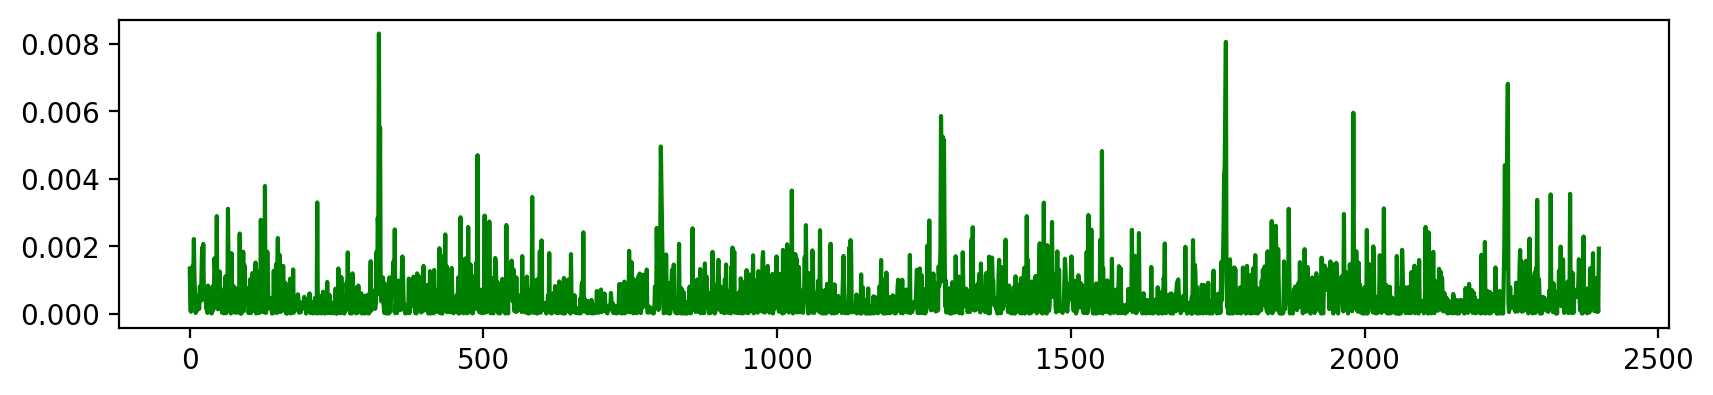

time: 145 ms (started: 2024-05-28 15:47:20 -07:00)


In [13]:
fig = plt.plot(test_reconerr_vanilla[:, [0]], color="g")

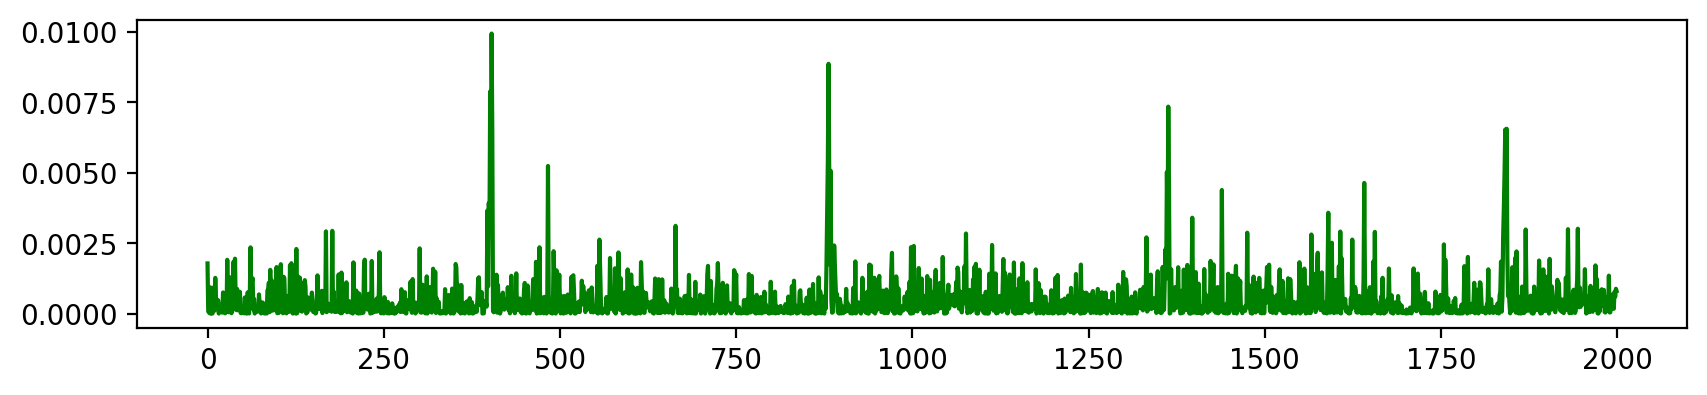

time: 145 ms (started: 2024-05-28 15:47:21 -07:00)


In [14]:
fig = plt.plot(val_reconerr_vanilla[:, [0]], color="g")

Show how the channels for the test data differ between the normal and the anomaly

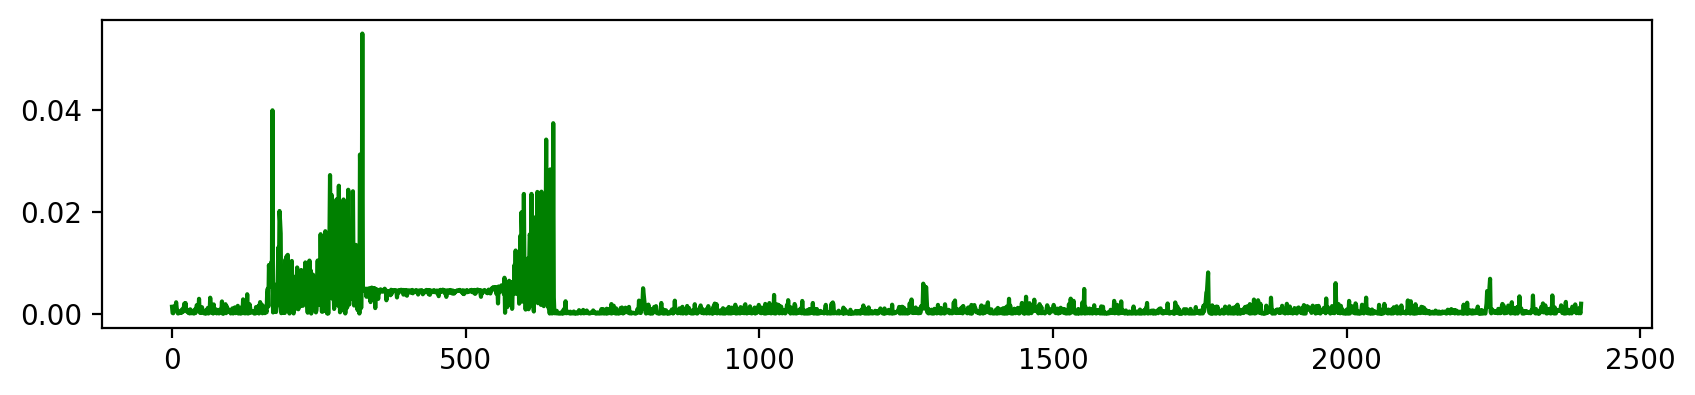

time: 117 ms (started: 2024-05-28 15:47:21 -07:00)


In [15]:
fig = plt.plot(test_reconerr_vanilla[:, [1]], color="g")

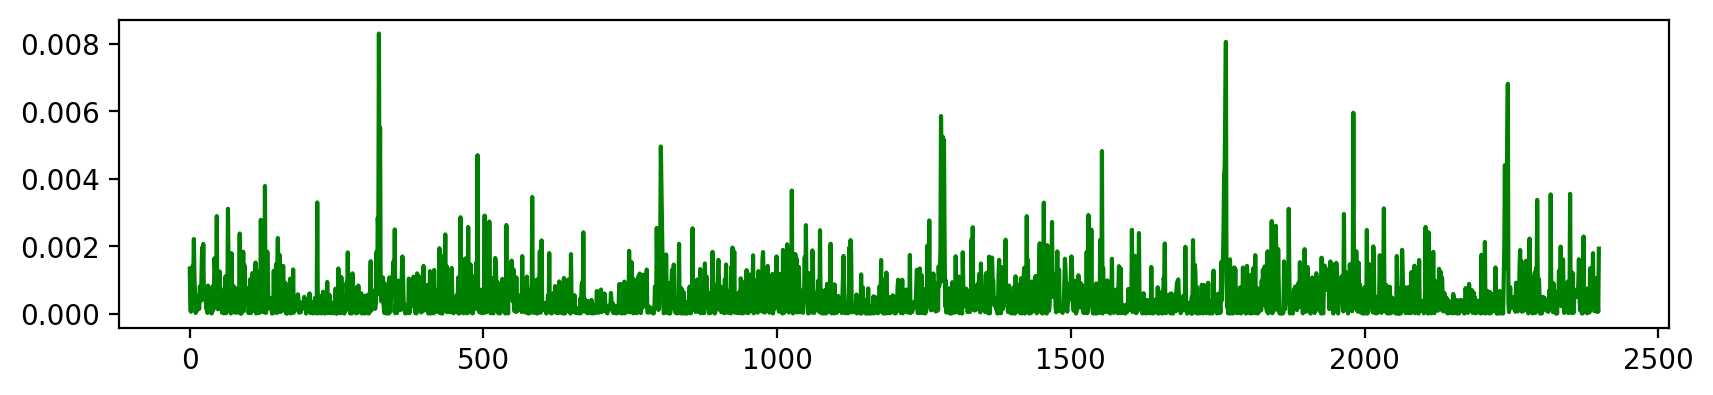

time: 136 ms (started: 2024-05-28 15:47:21 -07:00)


In [16]:
fig = plt.plot(test_reconerr_vanilla[:, [2]], color="g")

### Define a multichannel autoencoder model - constructed with three independent channel neural networks

In [17]:
from numalogic.models.autoencoder.variants import MultichannelAE
from numalogic.models.autoencoder import TimeseriesTrainer

model_multi = MultichannelAE(seq_len=SEQ_LEN, n_channels=3)
print(model_multi)

MultichannelAE(
  (channel_encoder0): _VanillaEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=12, out_features=16, bias=True)
      (1): Tanh()
      (2): Dropout(p=0.25, inplace=False)
      (3): Linear(in_features=16, out_features=8, bias=True)
      (4): Tanh()
      (5): Dropout(p=0.25, inplace=False)
    )
  )
  (channel_decoder0): _Decoder(
    (decoder): Sequential(
      (0): Linear(in_features=8, out_features=16, bias=True)
      (1): Tanh()
      (2): Dropout(p=0.25, inplace=False)
      (3): Linear(in_features=16, out_features=12, bias=True)
    )
  )
  (channel_encoder1): _VanillaEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=12, out_features=16, bias=True)
      (1): Tanh()
      (2): Dropout(p=0.25, inplace=False)
      (3): Linear(in_features=16, out_features=8, bias=True)
      (4): Tanh()
      (5): Dropout(p=0.25, inplace=False)
    )
  )
  (channel_decoder1): _Decoder(
    (decoder): Sequential(
      (0): Linear(in_features=8, ou

In [18]:
trainer = TimeseriesTrainer(max_epochs=MAX_EPOCHS, enable_progress_bar=True)
trainer.fit(model_multi, train_dataloaders=DataLoader(train_dataset, batch_size=BATCH_SIZE))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=40` reached.


time: 27.9 s (started: 2024-05-28 15:47:21 -07:00)


In [19]:
train_reconerr_multichannel = trainer.predict(
    model_multi, dataloaders=DataLoader(train_dataset, batch_size=BATCH_SIZE)
).numpy()
val_reconerr_multichannel = trainer.predict(
    model_multi, dataloaders=DataLoader(val_dataset, batch_size=BATCH_SIZE)
).numpy()
test_reconerr_multichannel = trainer.predict(
    model_multi, dataloaders=DataLoader(test_dataset, batch_size=BATCH_SIZE)
).numpy()

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

time: 420 ms (started: 2024-05-28 15:47:49 -07:00)


### Compare the reconstruction errors of the different channels - the second channel should have higher error for the anomaly

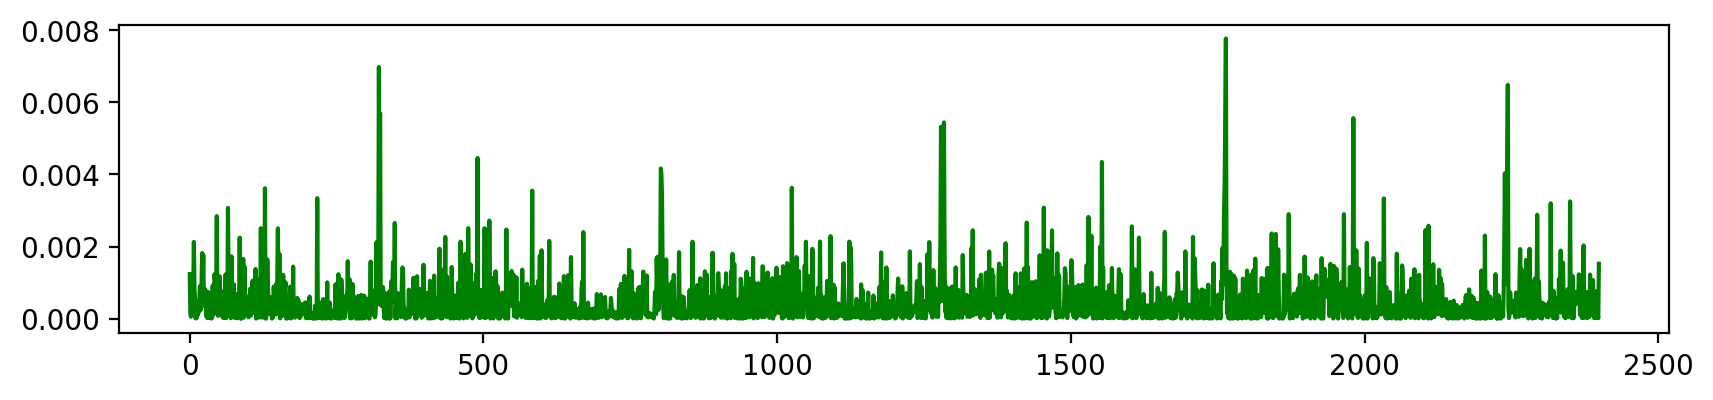

time: 130 ms (started: 2024-05-28 15:47:50 -07:00)


In [20]:
fig = plt.plot(test_reconerr_multichannel[:, [0]], color="g")

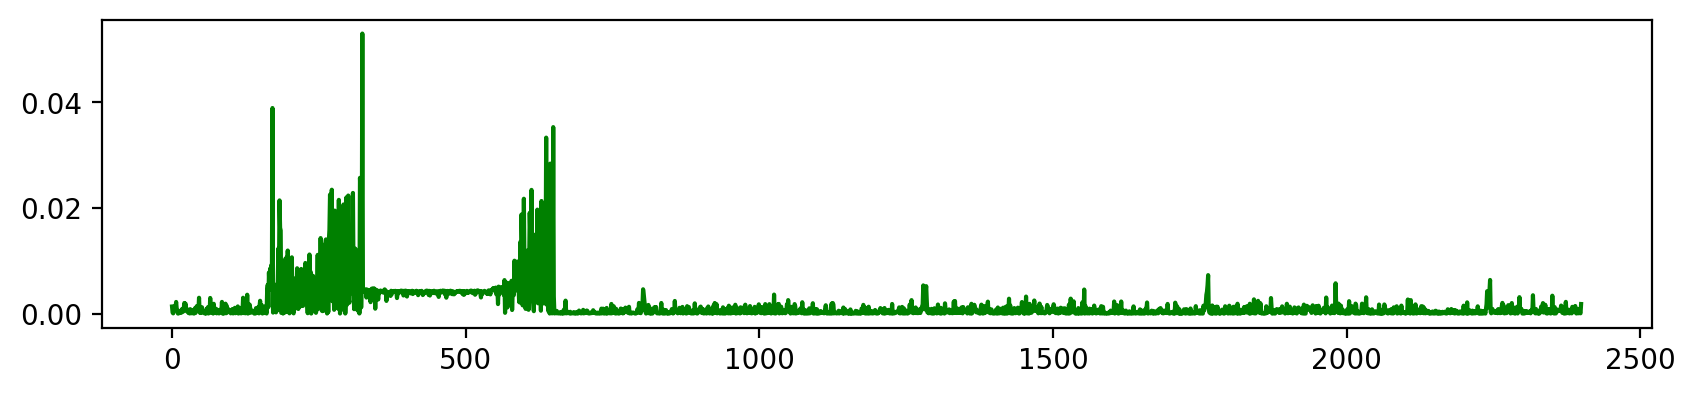

time: 115 ms (started: 2024-05-28 15:47:50 -07:00)


In [21]:
fig = plt.plot(test_reconerr_multichannel[:, [1]], color="g")

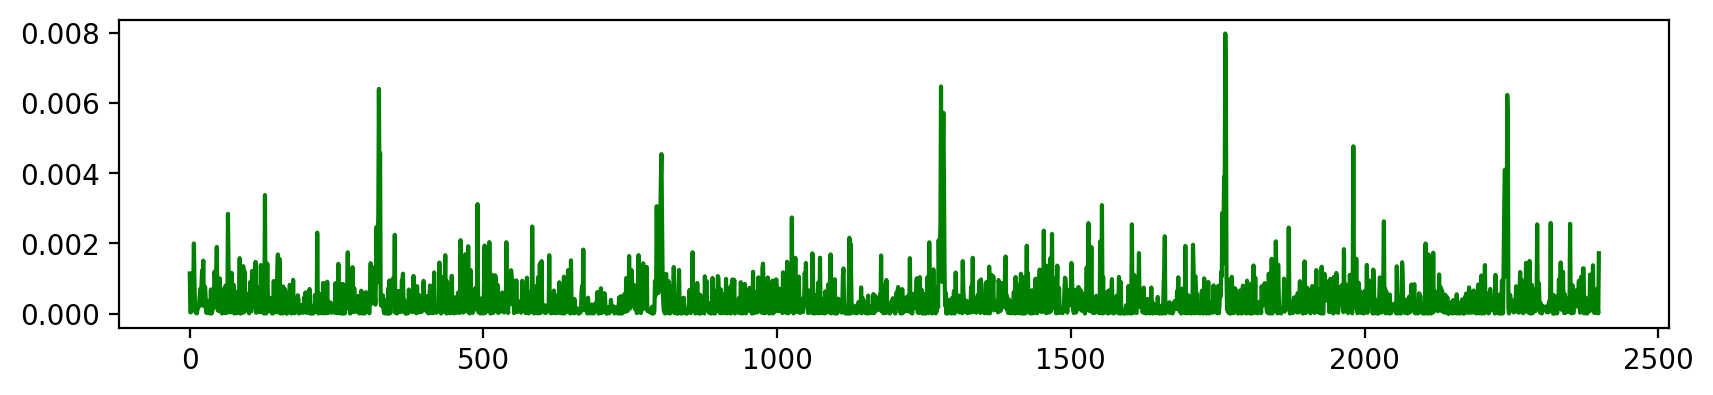

time: 129 ms (started: 2024-05-28 15:47:50 -07:00)


In [22]:
fig = plt.plot(test_reconerr_multichannel[:, [2]], color="g")